# Example

Use this example to ensure that you can import required libraries for the final project or delete it if you already have this set up.

If importing any of these libraries causes an error for you, be sure to fix this before the exam period.


### **1. Imports**

In [251]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision
import sklearn
import pandas as pd
import seaborn as sns
import scipy
import random as py_random
from torchvision import transforms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [252]:
# Importing modules
from finalproject.data_loader import LFWDataLoader
from finalproject.data import load_lfw, create_splits, NumpyFaceDataset
from finalproject.models import SmallCNN, ConvEncoder, ConvDecoder, train_autoencoder, train_classifier, extract_features
from finalproject.utils import set_seed
from finalproject.visualization import visualize_classifier_predictions, visualize_attack_results, visualize_real_vs_reconstructed
from finalproject.attack import nes_optimize, create_query_fn, create_defended_query_fn, run_attack_suite
from finalproject.detector import extract_window_features, train_detector, QueryPatternDetector
from finalproject.defense import defend_postprocess
from finalproject.metrics import compute_ssim, compute_psnr

In [253]:
print(np.__version__)
print(matplotlib.__version__)
print(torch.__version__)
print(torchvision.__version__)
print(sklearn.__version__)
print(pd.__version__)
print(sns.__version__)
print(scipy.__version__)

2.1.3
3.9.3
2.5.1
0.20.1
1.5.2
2.2.3
0.13.2
1.14.1


### **2. Testing Modules**

#### **2.1 Data Loader**

In [254]:
# Test the LFWDataLoader class
# Initialize the loader
loader = LFWDataLoader(
    data_home='../dataset/',
    min_faces_per_person=70,
    resize=0.4
)

# Load the dataset
loader.load()

# Access the data
print("Dataset shapes:")
print(f"Images: {loader.images.shape}")
print(f"Data: {loader.data.shape}")
print(f"Target: {loader.target.shape}")
print(f"\nTarget names: {[str(name) for name in loader.target_names]}")

# Get class distribution
distribution = loader.get_class_distribution()
print("\nClass distribution:")
for name, count in distribution.items():
    print(f"  {name}: {count} images")


Dataset will be saved to: ../dataset/
✓ Dataset directory already exists
  Location: /Users/sarthakchandervanshi/Desktop/Required/D Drive/Masters Data Science/Semesters/Semester 3/Special Topics in Data Science/pai/dataset/lfw_home
Dataset shapes:
Images: (1288, 50, 37)
Data: (1288, 1850)
Target: (1288,)

Target names: ['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush', 'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair']

Class distribution:
  Ariel Sharon: 77 images
  Colin Powell: 236 images
  Donald Rumsfeld: 121 images
  George W Bush: 530 images
  Gerhard Schroeder: 109 images
  Hugo Chavez: 71 images
  Tony Blair: 144 images


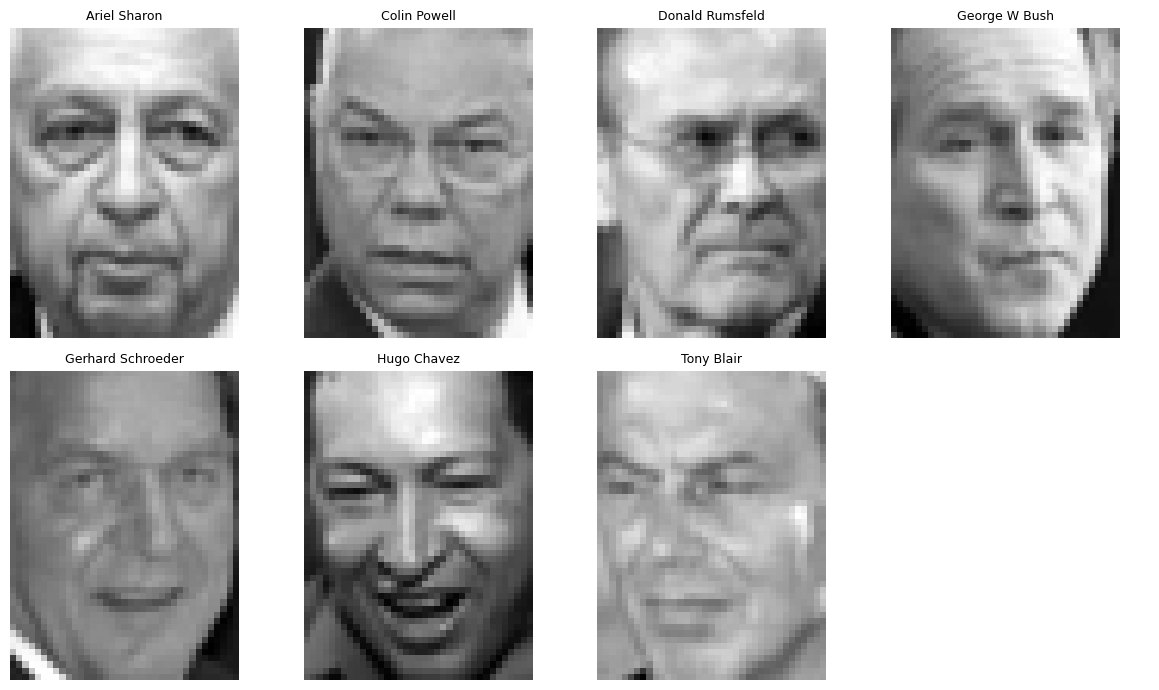

In [255]:
# 1 image per distinct person (7 people) in a grid
loader.show_distinct_people(n_cols=4, seed=42)


#### **2.2 Data**

In [256]:
# Test load_lfw function
X, y, target_names = load_lfw(
    min_faces_per_person=70,
    resize=0.4,
    data_home='../dataset/'
)

print("Data shapes:")
print(f"X: {X.shape}, y: {y.shape}")
print(f"Target names: {[str(name) for name in target_names]}")

# Test create_splits function
X_train, y_train, X_val, y_val, X_test, y_test = create_splits(
    X, y, test_size=0.2, val_size=0.1, random_state=42
)

print(f"\nSplit sizes:")
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# Test NumpyFaceDataset class
train_dataset = NumpyFaceDataset(X_train, y_train)
print(f"\nDataset length: {len(train_dataset)}")

sample_img, sample_label = train_dataset[0]
print(f"Sample image shape: {sample_img.shape}, label: {sample_label}")


Data shapes:
X: (1288, 50, 37), y: (1288,)
Target names: ['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush', 'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair']

Split sizes:
Train: 901, Val: 129, Test: 258

Dataset length: 901
Sample image shape: torch.Size([1, 50, 37]), label: 2


#### **2.3 Models**

In [257]:
# Test SmallCNN
num_classes = len(target_names)
model = SmallCNN(in_channels=1, num_classes=num_classes, dropout=0.3)
batch_size = 4
sample_input = torch.randn(batch_size, 1, 50, 37)

model.eval()
with torch.no_grad():
    output = model(sample_input)

assert output.shape == (batch_size, num_classes)
print(f"✓ SmallCNN: {output.shape}")


✓ SmallCNN: torch.Size([4, 7])


In [258]:
# Test ConvEncoder
latent_dim = 64
encoder = ConvEncoder(latent_dim=latent_dim, in_channels=1)

encoder.eval()
with torch.no_grad():
    encoded = encoder(sample_input)

assert encoded.shape == (batch_size, latent_dim)
print(f"✓ ConvEncoder: {encoded.shape}")


✓ ConvEncoder: torch.Size([4, 64])


In [259]:
# Test ConvDecoder
decoder = ConvDecoder(latent_dim=latent_dim, out_channels=1)

decoder.eval()
with torch.no_grad():
    decoded = decoder(encoded)

assert decoded.shape == (batch_size, 1, 50, 37)
print(f"✓ ConvDecoder: {decoded.shape}")


✓ ConvDecoder: torch.Size([4, 1, 50, 37])


In [260]:
# Test encoder-decoder round trip
with torch.no_grad():
    latent = encoder(sample_input)
    reconstructed = decoder(latent)

assert reconstructed.shape == sample_input.shape
mse = torch.nn.functional.mse_loss(sample_input, reconstructed).item()
print(f"✓ Encoder-Decoder round trip: MSE = {mse:.6f}")


✓ Encoder-Decoder round trip: MSE = 1.273780


In [261]:
# Test train_classifier
from finalproject.data import NumpyFaceDataset

train_ds_clf = NumpyFaceDataset(X_train[:64], y_train[:64], transform=transforms.ToTensor())
val_ds_clf = NumpyFaceDataset(X_val[:32], y_val[:32], transform=transforms.ToTensor())
test_model = SmallCNN(in_channels=1, num_classes=len(target_names), dropout=0.3)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_model = train_classifier(
    model=test_model,
    train_ds=train_ds_clf,
    val_ds=val_ds_clf,
    device=device,
    epochs=2,
    batch_size=32,
    patience=10
)

print("✓ train_classifier")


/Users/sarthakchandervanshi/Desktop/Required/D Drive/Masters Data Science/Semesters/Semester 3/Special Topics in Data Science/pai/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/2 | train_loss 1.8327 | val_loss 1.9267 | val_acc 0.2500 *
Epoch 2/2 | train_loss 1.6298 | val_loss 1.9022 | val_acc 0.3750 *
✓ train_classifier


In [262]:
# Test train_autoencoder
train_ds_ae = NumpyFaceDataset(X_train[:32], y=None, transform=transforms.ToTensor())
val_ds_ae = NumpyFaceDataset(X_val[:16], y=None, transform=transforms.ToTensor())
test_encoder = ConvEncoder(latent_dim=latent_dim, in_channels=1)
test_decoder = ConvDecoder(latent_dim=latent_dim, out_channels=1)

trained_encoder, trained_decoder = train_autoencoder(
    encoder=test_encoder,
    decoder=test_decoder,
    train_ds=train_ds_ae,
    val_ds=val_ds_ae,
    device=device,
    epochs=2,
    patience=10
)

print("✓ train_autoencoder")


AE epoch 1/2: train_loss 0.037001 (PSNR 14.79dB, acc 18.41%), val_loss 0.037957 (PSNR 14.81dB, acc 18.48%) *
AE epoch 2/2: train_loss 0.036947 (PSNR 14.80dB, acc 18.45%), val_loss 0.037904 (PSNR 14.82dB, acc 18.47%) *
✓ train_autoencoder


In [263]:
# Test extract_features
test_ds_features = NumpyFaceDataset(X_train[:32], y_train[:32], transform=transforms.ToTensor())
test_encoder_features = ConvEncoder(latent_dim=latent_dim, in_channels=1)

features, labels = extract_features(test_encoder_features, test_ds_features, device=device)

assert features.shape[0] == len(test_ds_features)
assert features.shape[1] == latent_dim
assert len(labels) == len(test_ds_features)
assert np.array_equal(labels, y_train[:32])

print(f"✓ extract_features: features shape {features.shape}, labels shape {labels.shape}")
print("\n✓ All models.py tests completed!")


✓ extract_features: features shape (32, 64), labels shape (32,)

✓ All models.py tests completed!


#### **2.4 Utils**

In [264]:
# Test utils.set_seed
set_seed(42)

val_py_1 = py_random.random()
val_np_1 = np.random.rand()
val_torch_1 = torch.rand(3)

set_seed(42)

val_py_2 = py_random.random()
val_np_2 = np.random.rand()
val_torch_2 = torch.rand(3)

assert val_py_1 == val_py_2
assert np.isclose(val_np_1, val_np_2)
assert torch.allclose(val_torch_1, val_torch_2)

print("✓ utils.set_seed reproducibility verified")


✓ utils.set_seed reproducibility verified


#### **2.5 Visualization**

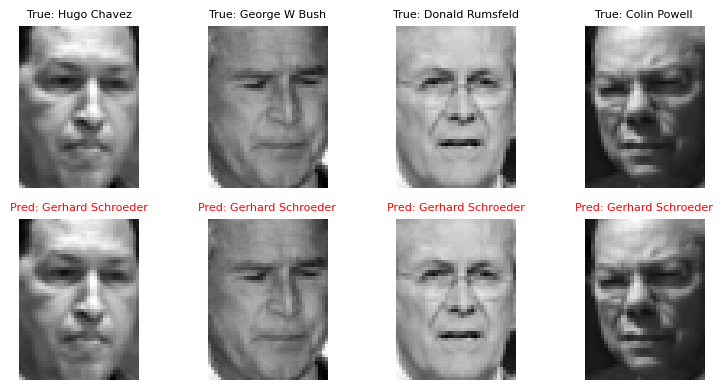

Sample batch accuracy: 0.00%
✓ visualize_classifier_predictions


In [265]:
# Test visualize_classifier_predictions
test_ds_viz = NumpyFaceDataset(X_test[:16], y_test[:16], transform=transforms.ToTensor())
test_model_viz = SmallCNN(in_channels=1, num_classes=len(target_names), dropout=0.3)
test_model_viz = test_model_viz.to(device)
test_model_viz.eval()

visualize_classifier_predictions(test_model_viz, test_ds_viz, target_names, device=device, num_images=4)

print("✓ visualize_classifier_predictions")


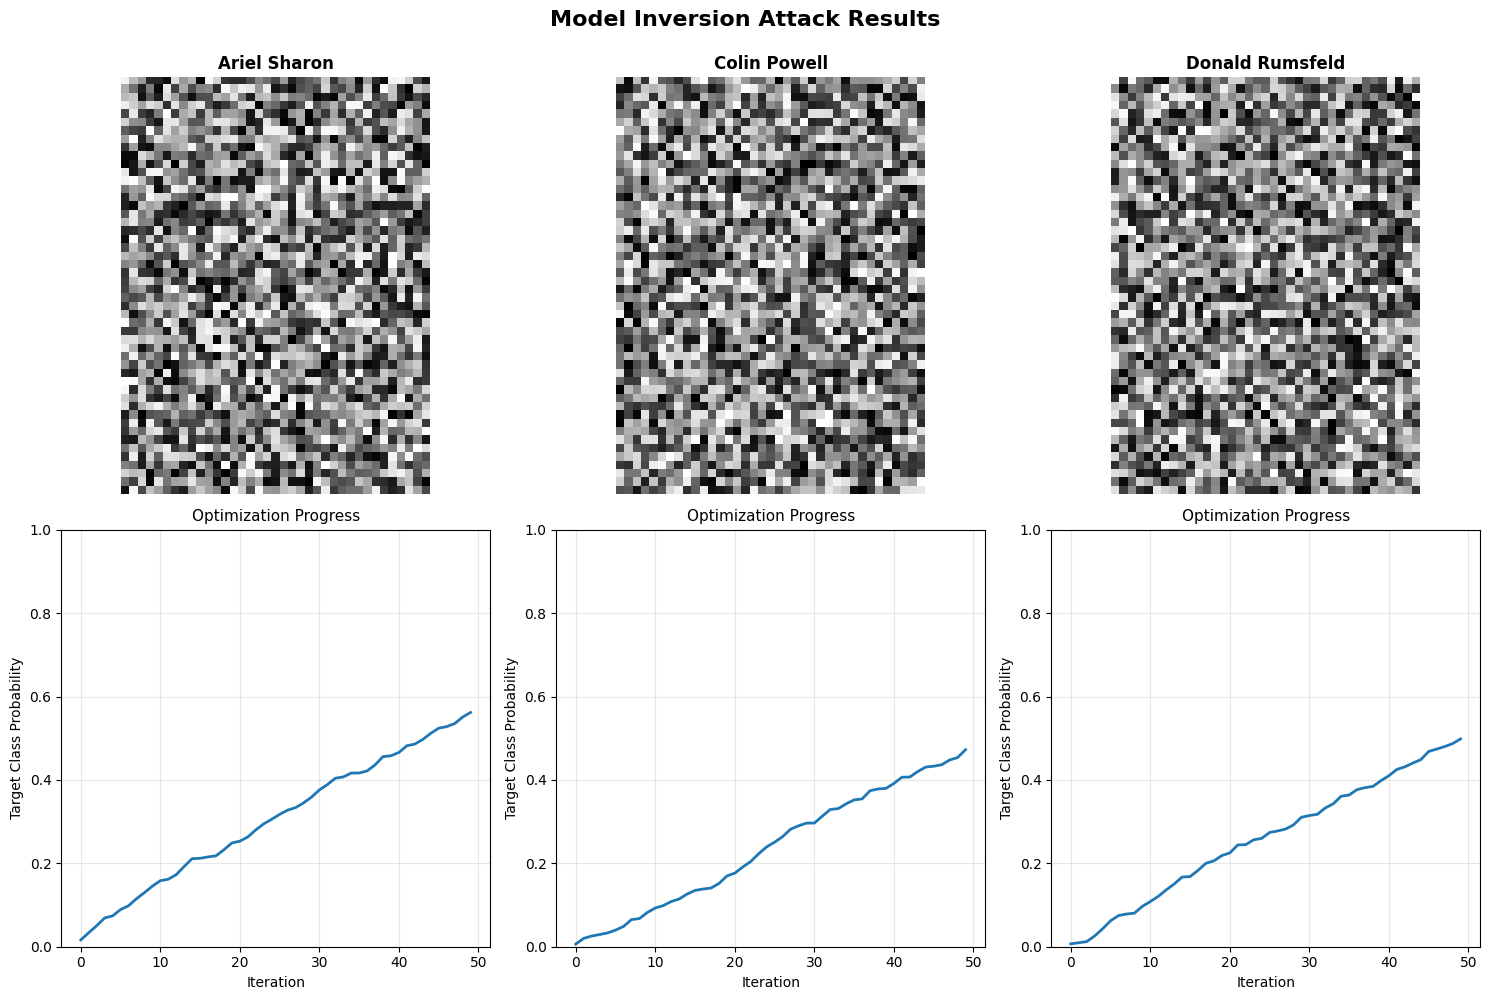


ATTACK SUMMARY
Ariel Sharon         | Queries: 500
Colin Powell         | Queries: 500
Donald Rumsfeld      | Queries: 500
✓ visualize_attack_results


In [266]:
# Test visualize_attack_results
nes_pop = 10
attack_results = {}

# Create mock attack results for a few classes
for class_idx in range(min(3, len(target_names))):
    # Generate mock data
    best_image = np.random.rand(50, 37)
    history = np.random.rand(50).cumsum() / 50  # Mock optimization history
    final_confidence = float(np.random.rand())
    
    attack_results[class_idx] = {
        'best_image': best_image,
        'history': history,
        'final_confidence': final_confidence
    }

visualize_attack_results(attack_results, nes_pop, target_names)
print("✓ visualize_attack_results")


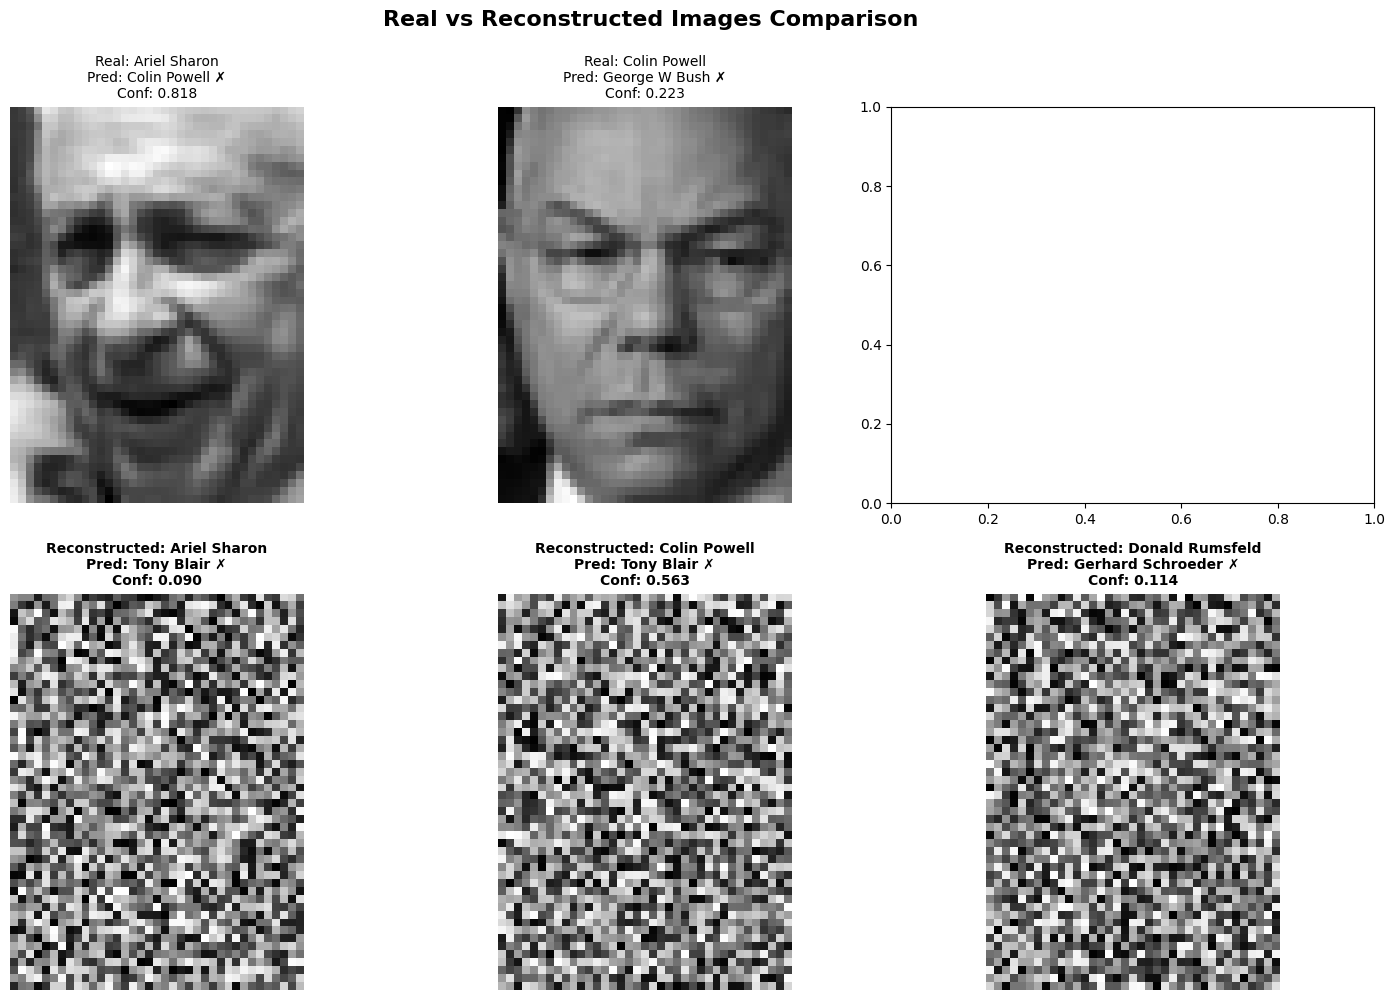

✓ visualize_real_vs_reconstructed

✓ All visualization.py tests completed!


In [267]:
# Test visualize_real_vs_reconstructed
target_class_indices = [0, 1, 2]  # Test with first 3 classes

# Create mock real images data
real_images = X_test[:10]
real_labels = y_test[:10]
real_predictions = np.random.randint(0, len(target_names), size=10)
real_confidences = np.random.rand(10)

# Create mock reconstructed images data
reconstructed_images = np.random.rand(3, 50, 37)  # 3 reconstructed images
reconstructed_labels = np.array(target_class_indices)
reconstructed_predictions = np.random.randint(0, len(target_names), size=3)
reconstructed_confidences = np.random.rand(3)

visualize_real_vs_reconstructed(
    real_images, real_labels, real_predictions, real_confidences,
    reconstructed_images, reconstructed_labels, reconstructed_predictions, reconstructed_confidences,
    target_names, target_class_indices
)

print("✓ visualize_real_vs_reconstructed")
print("\n✓ All visualization.py tests completed!")


#### **2.6 Attack**

In [268]:
# Test create_query_fn
test_model_query = SmallCNN(in_channels=1, num_classes=len(target_names), dropout=0.3)
test_model_query = test_model_query.to(device)
test_model_query.eval()

query_fn = create_query_fn(test_model_query, device=device, num_classes=len(target_names))

# Test query function with a sample image
sample_img = X_test[0]
probs = query_fn(sample_img)

assert len(probs) == len(target_names)
assert np.isclose(probs.sum(), 1.0, atol=1e-5)
assert np.all(probs >= 0) and np.all(probs <= 1)

print(f"✓ create_query_fn: probabilities shape {probs.shape}, sum = {probs.sum():.6f}")


✓ create_query_fn: probabilities shape (7,), sum = 1.000000


In [269]:
# Test nes_optimize (simplified with fewer iterations)
test_decoder_attack = ConvDecoder(latent_dim=latent_dim, out_channels=1)
test_decoder_attack = test_decoder_attack.to(device)

test_query_fn = create_query_fn(test_model_query, device=device, num_classes=len(target_names))

# Run a quick NES optimization for one class
target_class_idx = 0
best_z, history, best_image = nes_optimize(
    decoder=test_decoder_attack,
    query_fn=test_query_fn,
    class_index=target_class_idx,
    latent_dim=latent_dim,
    pop=10,
    sigma=0.1,
    lr=0.01,
    iters=5,
    device=device,
    latent_reg=0.01,
    sigma_anneal=False,
    min_iters=3,
    use_antithetic=True
)

assert best_z.shape == (latent_dim,)
assert len(history) <= 5
assert best_image.shape == (50, 37)

print(f"✓ nes_optimize: best_z shape {best_z.shape}, history length {len(history)}, best_image shape {best_image.shape}")


NES Optimization: 100%|██████████| 5/5 [00:00<00:00, 77.41it/s]

✓ nes_optimize: best_z shape (64,), history length 5, best_image shape (50, 37)


In [270]:
# Test run_attack_suite (simplified with fewer iterations and classes)
test_target_classes = [0, 1]  # Test with first 2 classes

attack_results = run_attack_suite(
    decoder=test_decoder_attack,
    query_fn=test_query_fn,
    target_names=target_names,
    target_classes=test_target_classes,
    device=device,
    nes_sigma=0.1,
    nes_pop=10,
    nes_iters=3,
    latent_dim=latent_dim,
    lr=0.01,
    latent_reg=0.01,
    sigma_anneal=False,
    min_iters=2
)

assert len(attack_results) == len(test_target_classes)
for class_idx in test_target_classes:
    assert class_idx in attack_results
    result = attack_results[class_idx]
    assert 'best_image' in result
    assert 'history' in result
    assert 'final_confidence' in result
    assert result['best_image'].shape == (50, 37)

print(f"✓ run_attack_suite: tested {len(attack_results)} classes")


Attack Configuration:
  Population size: 10
  Noise scale (sigma): 0.1
  Iterations: 3
  Latent dimension: 64
  Total queries per attack (upper bound): 30

Attacking target class: Ariel Sharon (index 0)


NES Optimization: 100%|██████████| 3/3 [00:00<00:00, 64.06it/s]



Final confidence for Ariel Sharon
Prediction: Ariel Sharon
Total queries used: 30

Attacking target class: Colin Powell (index 1)


NES Optimization: 100%|██████████| 3/3 [00:00<00:00, 66.47it/s]


Final confidence for Colin Powell
Prediction: Ariel Sharon
Total queries used: 30
✓ run_attack_suite: tested 2 classes


In [271]:
# Test create_defended_query_fn
defense_config = {'topk': 3, 'decimals': 2, 'add_noise': False}

defended_query_fn = create_defended_query_fn(
    test_model_query, 
    device=device, 
    num_classes=len(target_names),
    defense_config=defense_config
)

# Test defended query function with a sample image
sample_img_defended = X_test[0]
defended_probs = defended_query_fn(sample_img_defended)

assert len(defended_probs) == len(target_names)
assert np.isclose(defended_probs.sum(), 1.0, atol=1e-5)
assert np.all(defended_probs >= 0) and np.all(defended_probs <= 1)

# With topk=3, should have at most 3 non-zero values (before rounding)
non_zero_before_rounding = np.count_nonzero(defended_probs)
# Note: After rounding, some values might become zero, so we just check it's reasonable
assert non_zero_before_rounding <= len(target_names)

print(f"✓ create_defended_query_fn: defended probabilities shape {defended_probs.shape}, sum = {defended_probs.sum():.6f}")
print("\n✓ All attack.py tests completed!")


✓ create_defended_query_fn: defended probabilities shape (7,), sum = 1.000000

✓ All attack.py tests completed!


#### **2.7 Detector**

In [272]:
# Test extract_window_features
window_size = 10
num_classes = len(target_names)

# Create mock probability windows
probs_window = []
for i in range(window_size):
    # Create random softmax probabilities
    probs = np.random.rand(num_classes)
    probs = probs / probs.sum()
    probs_window.append(probs)

features = extract_window_features(probs_window)

assert features.shape == (6,)
assert np.all(np.isfinite(features))
assert features[5] >= 0 and features[5] <= 1  # top1_stability should be in [0, 1]

print(f"✓ extract_window_features: features shape {features.shape}")


✓ extract_window_features: features shape (6,)


In [273]:
# Test train_detector
# Create mock benign window features
n_windows = 50
benign_features = np.random.rand(n_windows, 6)

detector_model = train_detector(benign_features, contamination=0.01, random_state=42)

# Test that detector can predict
test_features = np.random.rand(5, 6)
predictions = detector_model.predict(test_features)

assert len(predictions) == 5
assert all(pred in [-1, 1] for pred in predictions)  # -1 = anomaly, 1 = normal

print(f"✓ train_detector: trained detector, predictions shape {predictions.shape}")


✓ train_detector: trained detector, predictions shape (5,)


In [274]:
# Test QueryPatternDetector without detector (just feature extraction)
detector_no_model = QueryPatternDetector(window_size=5, detector=None)

# Add queries until window is full
client_id = "test_client"
for i in range(5):
    probs = np.random.rand(num_classes)
    probs = probs / probs.sum()
    is_anomaly, features = detector_no_model.add_query(client_id, probs)
    
    if i < 4:
        assert is_anomaly is None  # Window not full yet
    else:
        assert is_anomaly is None  # No detector model
        assert features is not None
        assert features.shape == (6,)

print(f"✓ QueryPatternDetector (without model): features extracted when window full")


✓ QueryPatternDetector (without model): features extracted when window full


In [275]:
# Test QueryPatternDetector with trained detector
detector_with_model = QueryPatternDetector(window_size=5, detector=detector_model)

# Add queries until window is full
client_id_2 = "test_client_2"
for i in range(6):  # Add one extra to ensure window is full
    probs = np.random.rand(num_classes)
    probs = probs / probs.sum()
    result = detector_with_model.add_query(client_id_2, probs)
    is_anomaly, features = result
    
    if i < 4:
        # Window not full yet (0, 1, 2, 3)
        assert is_anomaly is None
        assert features is None
    else:
        # Window is full (i >= 4), should return boolean and features
        # Note: numpy comparisons return numpy.bool_, which is fine
        assert isinstance(is_anomaly, (bool, np.bool_)), f"Expected bool or numpy.bool_, got {type(is_anomaly)}: {is_anomaly}"
        assert features is not None
        assert features.shape == (6,)

print(f"✓ QueryPatternDetector (with model): anomaly detection working")
print("\n✓ All detector.py tests completed!")


✓ QueryPatternDetector (with model): anomaly detection working

✓ All detector.py tests completed!


#### **2.8 Defense**

In [276]:
# Test defend_postprocess - basic functionality
test_probs = np.array([0.1, 0.2, 0.3, 0.4])
defended = defend_postprocess(test_probs)

assert defended.shape == test_probs.shape
assert np.isclose(defended.sum(), 1.0, atol=1e-10)
assert np.all(defended >= 0) and np.all(defended <= 1)

print(f"✓ defend_postprocess (basic): probabilities sum to {defended.sum():.6f}")


✓ defend_postprocess (basic): probabilities sum to 1.000000


In [277]:
# Test defend_postprocess - topk filtering
defended_topk = defend_postprocess(test_probs, topk=2)

# Should only have 2 non-zero values
non_zero_count = np.count_nonzero(defended_topk)
assert non_zero_count == 2
assert np.isclose(defended_topk.sum(), 1.0, atol=1e-10)

print(f"✓ defend_postprocess (topk=2): {non_zero_count} non-zero probabilities")


✓ defend_postprocess (topk=2): 2 non-zero probabilities


In [278]:
# Test defend_postprocess - rounding
defended_round = defend_postprocess(test_probs, decimals=2)

# Check that values are rounded to 2 decimal places
for val in defended_round:
    decimal_places = len(str(val).split('.')[-1]) if '.' in str(val) else 0
    assert decimal_places <= 2

assert np.isclose(defended_round.sum(), 1.0, atol=1e-10)

print(f"✓ defend_postprocess (decimals=2): probabilities rounded")


✓ defend_postprocess (decimals=2): probabilities rounded


In [279]:
# Test defend_postprocess - adding noise
rng = np.random.default_rng(42)
defended_noise = defend_postprocess(test_probs, add_noise=True, rng=rng)

assert defended_noise.shape == test_probs.shape
assert np.isclose(defended_noise.sum(), 1.0, atol=1e-10)
assert np.all(defended_noise >= 0) and np.all(defended_noise <= 1)

# With noise, probabilities should be slightly different
assert not np.allclose(defended_noise, test_probs, atol=1e-6)

print(f"✓ defend_postprocess (add_noise=True): noise added, sum = {defended_noise.sum():.6f}")


✓ defend_postprocess (add_noise=True): noise added, sum = 1.000000


In [280]:
# Test defend_postprocess - combined defenses
defended_combined = defend_postprocess(test_probs, topk=3, decimals=2, add_noise=True, rng=rng)

assert defended_combined.shape == test_probs.shape
assert np.isclose(defended_combined.sum(), 1.0, atol=1e-10)
assert np.all(defended_combined >= 0) and np.all(defended_combined <= 1)

# Note: After adding noise, previously zero values (from topk) might become non-zero
# So we verify the function works correctly with all defenses combined
# The top 3 original values should still be among the largest
top3_indices = np.argsort(defended_combined)[-3:]
assert len(top3_indices) == 3

print(f"✓ defend_postprocess (combined): topk=3, decimals=2, noise=True")
print("\n✓ All defense.py tests completed!")


✓ defend_postprocess (combined): topk=3, decimals=2, noise=True

✓ All defense.py tests completed!


#### **2.9 Metrics**

In [281]:
# Test compute_ssim
# Create two test images
img1 = np.random.rand(50, 37)
img2 = img1.copy()  # Same image should have SSIM = 1.0

ssim_same = compute_ssim(img1, img2)
assert np.isclose(ssim_same, 1.0, atol=1e-5), f"Same images should have SSIM=1.0, got {ssim_same}"

# Test with different images
img3 = np.random.rand(50, 37)
ssim_diff = compute_ssim(img1, img3)

# SSIM can range from -1 to 1 (negative values indicate very different images)
assert -1.0 <= ssim_diff <= 1.0, f"SSIM should be in [-1, 1], got {ssim_diff}"
assert ssim_diff < 1.0, "Different images should have SSIM < 1.0"

print(f"✓ compute_ssim: same images SSIM={ssim_same:.6f}, different images SSIM={ssim_diff:.6f}")


✓ compute_ssim: same images SSIM=1.000000, different images SSIM=-0.004806


In [282]:
# Test compute_psnr
# Same images should have infinite PSNR
psnr_same = compute_psnr(img1, img2)
assert psnr_same == float('inf'), f"Same images should have PSNR=inf, got {psnr_same}"

# Test with different images
psnr_diff = compute_psnr(img1, img3)

assert psnr_diff > 0, f"PSNR should be positive, got {psnr_diff}"
assert np.isfinite(psnr_diff), f"PSNR should be finite for different images, got {psnr_diff}"

print(f"✓ compute_psnr: same images PSNR={psnr_same}, different images PSNR={psnr_diff:.2f} dB")


✓ compute_psnr: same images PSNR=inf, different images PSNR=7.82 dB


In [283]:
# Test compute_ssim and compute_psnr with noisy image
# Add small noise to image
noise = np.random.rand(50, 37) * 0.1
img_noisy = np.clip(img1 + noise, 0, 1)

ssim_noisy = compute_ssim(img1, img_noisy)
psnr_noisy = compute_psnr(img1, img_noisy)

assert -1.0 <= ssim_noisy <= 1.0, f"SSIM with noise should be in [-1, 1], got {ssim_noisy}"
assert ssim_noisy < 1.0, "Noisy image should have SSIM < 1.0"
assert psnr_noisy > 0 and np.isfinite(psnr_noisy), f"PSNR with noise should be positive and finite, got {psnr_noisy}"
assert ssim_noisy > ssim_diff, "Noisy image should have higher SSIM than completely different image"
assert psnr_noisy > psnr_diff, "Noisy image should have higher PSNR than completely different image"

print(f"✓ compute_ssim (noisy): SSIM={ssim_noisy:.6f}")
print(f"✓ compute_psnr (noisy): PSNR={psnr_noisy:.2f} dB")
print("\n✓ All metrics.py tests completed!")


✓ compute_ssim (noisy): SSIM=0.990269
✓ compute_psnr (noisy): PSNR=24.82 dB

✓ All metrics.py tests completed!
